# Сверточная нейронная сеть с нуля

## Используемые библиотеки

In [2]:
import keras
import shutil, os
import numpy as np
from keras import layers
from keras import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

## Константы

In [3]:
BATCH_SIZE = 20

## Загрузка данных

### Скачивание датасета с Yandex Disk

In [6]:
# %pip install requests urllib if needed

import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/c-mfvkkpPAGZFQ'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = '../data/cat-vs-dog/src'
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

In [7]:
!mv ../data/cat-vs-dog/src/cat-vs-dog ../data/cat-vs-dog/src/train

### Для обучения отберем по 2000 экземпляров классов
Использование полного датасета затратно по вычислительным ресурсам

In [8]:
train_path = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'train')
test_path = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'test')
valid_path = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'val')
src_data = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'src', 'train')

In [9]:
PARAMS = {
    'samples': [
        {
            'train': 1000
        },
        {
            'val': 500
        },
        {
            'test': 500
        }
    ],
    'classes': ['cat', 'dog'],
    'count_all_instances': 2000
}

In [10]:
paths_to_classes = {}

for tag in PARAMS['classes']:
    paths_to_classes[tag] = []

In [11]:
for path in os.listdir(src_data):
    target = paths_to_classes['cat'] if 'cat' in path else paths_to_classes['dog']
    
    if len(target) < PARAMS['count_all_instances']:
        target.append(f'{src_data}/{path}')

In [12]:
paths = dict()

for sample in PARAMS['samples']:
    name, count = list(sample.items())[0]
    paths[name] = dict()
    
    for tag in PARAMS['classes']:
        paths[name][tag] = paths_to_classes[tag][:count]
        paths_to_classes[tag] = paths_to_classes[tag][count:]

In [13]:
shutil.rmtree(os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn'),  ignore_errors=True)

In [14]:
for sample in PARAMS['samples']:
    name, _ = list(sample.items())[0]
    
    for tag in PARAMS['classes']:
        os.makedirs(os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', name, tag))

In [15]:
for sample in PARAMS['samples']:
    name, _ = list(sample.items())[0]
    
    for tag in PARAMS['classes']:
        for instance in paths[name][tag]:
            shutil.copy(instance, os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', name, tag))

### Предварительная обработка данных

In [75]:
#!g2.mig
train_data = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_data = ImageDataGenerator(rescale=1/255)

In [76]:
#!g2.mig
train_generator = train_data.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = train_data.flow_from_directory(
    valid_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = test_data.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


 ##  Конструирование сети

In [77]:
#!g2.mig
model = Sequential()

# Сверточная основа
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Полносвязный классификатор
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [78]:
#!g2.mig
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [79]:
#!g2.mig
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Обучение сети

In [80]:
#!g2.mig
history = model.fit(
    train_generator,
    steps_per_epoch=2000/BATCH_SIZE, # count data elements / batch size
    epochs=30,
    validation_data=valid_generator,
    validation_steps=1000/BATCH_SIZE
)

Epoch 1/30
100/100 [==============================] - 20s 166ms/step - loss: 0.7378 - acc: 0.5355 - val_loss: 0.6916 - val_acc: 0.5070
Epoch 2/30
100/100 [==============================] - 15s 152ms/step - loss: 0.6934 - acc: 0.5495 - val_loss: 0.6768 - val_acc: 0.5470
Epoch 3/30
100/100 [==============================] - 14s 139ms/step - loss: 0.6817 - acc: 0.5745 - val_loss: 0.7231 - val_acc: 0.5360
Epoch 4/30
100/100 [==============================] - 14s 138ms/step - loss: 0.6784 - acc: 0.5860 - val_loss: 0.6750 - val_acc: 0.6210
Epoch 5/30
100/100 [==============================] - 14s 138ms/step - loss: 0.6771 - acc: 0.5940 - val_loss: 0.6502 - val_acc: 0.6060
Epoch 6/30
100/100 [==============================] - 14s 138ms/step - loss: 0.6685 - acc: 0.6060 - val_loss: 0.6897 - val_acc: 0.5820
Epoch 7/30
100/100 [==============================] - 14s 137ms/step - loss: 0.6548 - acc: 0.6120 - val_loss: 0.6402 - val_acc: 0.6340
Epoch 8/30
100/100 [==============================] - 1

In [81]:
model.save('cat_vs_dog.h5')

In [82]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [83]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_acc']

epochs = range(len(acc))

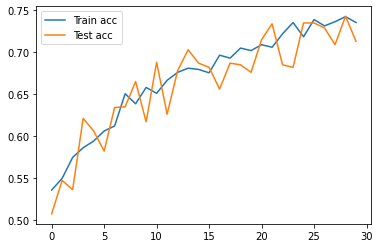

In [84]:
plt.plot(epochs, acc, label='Train acc')
plt.plot(epochs, val_acc, label='Test acc')
plt.legend()

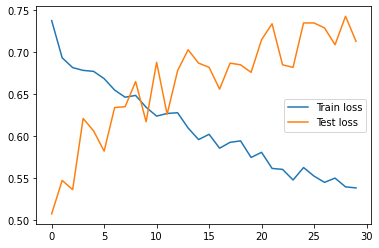

In [85]:
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Test loss')
plt.legend()

## Выводы

Метрики различных моделей:

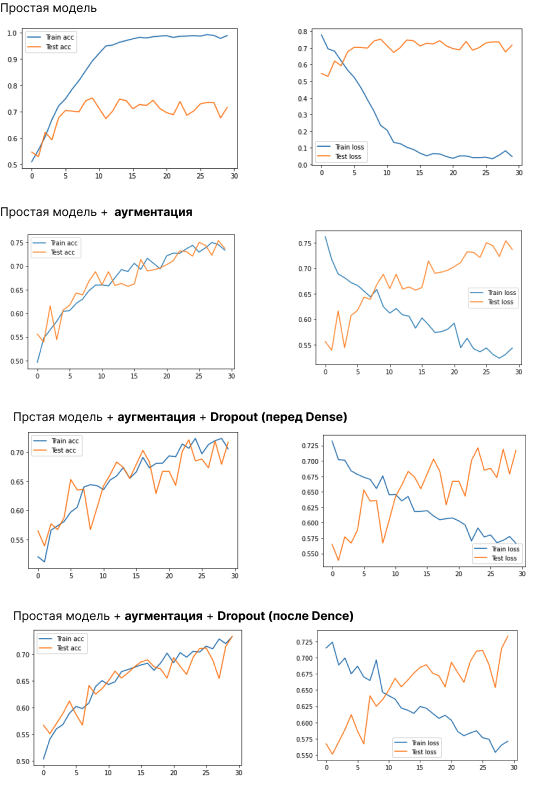

- Применение аугментаций позволило избавиться от быстроого переобучения модели и повысить точнось распознования.
- Dropout на качество модели повлиял не сильно